# Homework05: MNIST Deep Convolutional GAN to Generate MNIST digits

In [1]:
import numpy
import tensorflow
from tensorflow.keras.datasets import imdb, mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN, Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm_notebook
# fix random seed for reproducibility
numpy.random.seed(1)

#### Homework 05

1. Adapt the MNIST GAN implementation (see Lab09) to build CNN models instead of feedforwards.
2. Try different noise dimensions
3. Try implementing some training tricks suggested in https://github.com/soumith/ganhacks and study incremental improvements.

In [2]:
#data
(X_train, Y_train), (X_test, Y_test) =  mnist.load_data()

In [3]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

In [4]:
z_dim = 60

In [5]:
X_train.shape

(60000, 28, 28, 1)

In [6]:
adam = Adam(lr=0.0002, beta_1=0.5)
n_nodes = 128 * 7 * 7

#GENERATOR
g = Sequential()
g.add(Dense(n_nodes, input_shape=(z_dim,)))
g.add(LeakyReLU(alpha=0.3))
g.add(Reshape((7, 7, 128)))
g.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
g.add(LeakyReLU(alpha=0.3))
g.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
g.add(LeakyReLU(alpha=0.3))
g.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))



#DISCRIMINATOR
d = Sequential()
d.add(Conv2D(64, kernel_size=4, strides=(2, 2), padding='same', activation='relu', input_shape=(28, 28, 1)))
d.add(Dropout(0.3))
d.add(Conv2D(128, kernel_size=4, strides=(2, 2), padding='same', activation='relu'))
d.add(Dropout(0.3))
d.add(Flatten())
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


#GAN
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

/home/clusterusers/rriege/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            
            # Create Y labels similar to last exercise.
            y1 = np.zeros(2*BATCH_SIZE)
            y1[:BATCH_SIZE] =1 

            # Train gan and disrciminator similar to last exercise.
            ##YOUR CODE HERE###
            d.trainable = True
            d_loss = d.train_on_batch(X, y1)
            
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2) 

        # Only store losses from final
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


<ipython-input-8-d619700b2202>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(1, epochs+1)):


--------------- Epoch 1 ---------------


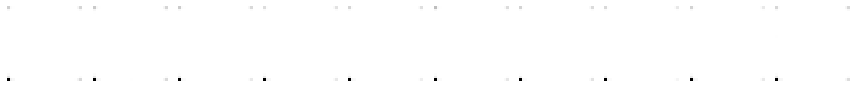

--------------- Epoch 40 ---------------


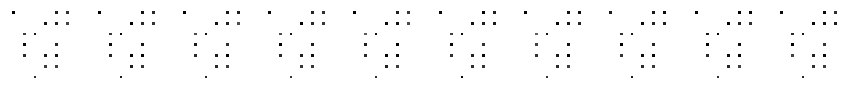

--------------- Epoch 80 ---------------


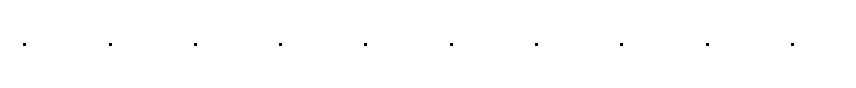

--------------- Epoch 120 ---------------


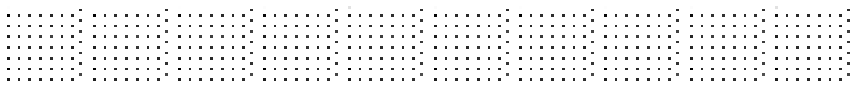

--------------- Epoch 160 ---------------


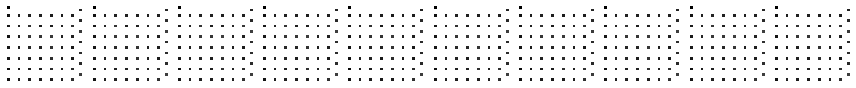

--------------- Epoch 200 ---------------


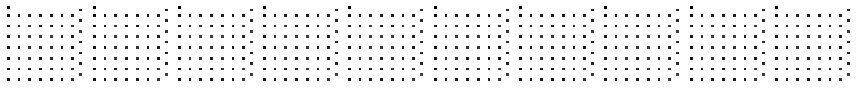

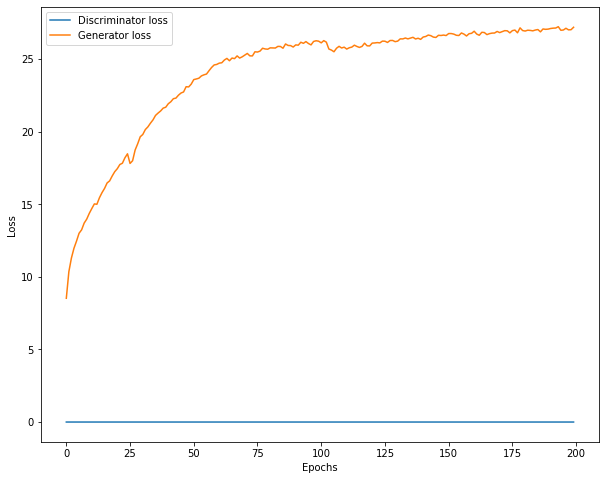

In [9]:
train(epochs=200, plt_frq=40, BATCH_SIZE=128)